In [2]:
import numpy as np
from obp.dataset import logistic_reward_function
from obp.dataset import SyntheticBanditDatasetWithActionEmbeds
from obp.ope import InverseProbabilityWeighting as IPS
import pandas as pd
from policy import gen_eps_greedy

from src.utils import read_yaml

In [3]:
random_state = 1234

In [31]:
cfg = read_yaml('src/phase1/config.yaml')

dataset = SyntheticBanditDatasetWithActionEmbeds(
    n_actions=cfg['n_actions'],
    dim_context=cfg['dim_context'],
    beta=cfg['beta'],
    reward_type="binary",
    n_cat_per_dim=cfg['n_cat_per_dim'],
    latent_param_mat_dim=cfg['latent_param_mat_dim'],
    n_cat_dim=cfg['n_cat_dim'],
    n_unobserved_cat_dim=cfg['n_unobserved_cat_dim'],
    n_deficient_actions=int(cfg['n_actions'] * cfg['n_def_actions']),
    reward_function=logistic_reward_function,
    reward_std=cfg['reward_std'],
    random_state=random_state,
)

# ### test bandit data is used to approximate the ground-truth policy value
# test_bandit_data = dataset.obtain_batch_bandit_feedback(
#     n_rounds=cfg['n_test_data']
# )

# action_dist_test = gen_eps_greedy(
#     expected_reward=test_bandit_data["expected_reward"],
#     is_optimal=cfg['is_optimal'],
#     eps=cfg['eps'],
# )
# policy_value = dataset.calc_ground_truth_policy_value(
#     expected_reward=test_bandit_data["expected_reward"],
#     action_dist=action_dist_test,
# )

In [32]:
from obp.ope import ImportanceWeightEstimator
from tqdm import tqdm 
from sklearn.neural_network import MLPClassifier

from obp.ope import OffPolicyEvaluation
from obp.ope import BalancedInverseProbabilityWeighting as BIPW
from obp.ope import ImportanceWeightEstimator
from obp.ope import SelfNormalizedMarginalizedInverseProbabilityWeighting as SMIPS

from src.custom_estimators import NaiveMethod as NM
from src.custom_estimators import RECAP

def ope(eps = cfg['eps']):

    result = []

    for _ in tqdm(range(1)):

        val_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=cfg['n_val_data'],
        )

        action_dist_val = gen_eps_greedy(
            expected_reward=val_bandit_data["expected_reward"],
            is_optimal=cfg['is_optimal'],
            eps=eps,
        )

        pol_val = dataset.calc_ground_truth_policy_value(
            expected_reward=val_bandit_data["expected_reward"],
            action_dist=action_dist_val,
        )

        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        action_context_t = scaler.fit_transform(val_bandit_data["action_context"])

        model = MLPClassifier(hidden_layer_sizes=(32,32))
        model = MLPClassifier(hidden_layer_sizes=(32,32,32), activation='relu', max_iter=400)
        iw_estimator = ImportanceWeightEstimator(base_model=model,
                                                n_actions=val_bandit_data["n_actions"], 
                                                action_context=action_context_t)
        
        if True:
            imp_weights = iw_estimator.fit_predict(context=val_bandit_data["context"],
                                                    action=val_bandit_data["action"],
                                                    action_dist=action_dist_val,
                                                    random_state=random_state)
            
            X1, X2 = None, None
        else:
            from obp.utils import sample_action_fast
            from densratio import densratio

            position = np.zeros_like(val_bandit_data["action"])
            n = val_bandit_data["context"].shape[0]

            sampled_action = np.zeros(n, dtype=int)
            if iw_estimator.fitting_method == "sample":
                for pos_ in np.arange(iw_estimator.len_list):
                    idx = position == pos_
                    sampled_action_at_position = sample_action_fast(
                        action_dist=action_dist_val[idx][:, :, pos_],
                        random_state=1234,
                    )
                    sampled_action[idx] = sampled_action_at_position

            for pos_ in np.arange(iw_estimator.len_list):
                idx = position == pos_
                action_dist_at_pos = action_dist_val[idx][:, :, pos_]
                X, y = iw_estimator._pre_process_for_clf_model(
                    context=val_bandit_data["context"][idx],
                    action=val_bandit_data["action"][idx],
                    action_dist_at_pos=action_dist_at_pos,
                    sampled_action_at_position=sampled_action[idx],
                )

            X1 = X[:int(len(X)/2)]
            X2 = X[int(len(X)/2):]
            # sigma_range=[0.1, 0.3, 0.5, 0.7, 1]
            # lambda_range=[0.01, 0.02, 0.03, 0.04, 0.05]
            # densratio_obj = densratio(X2, X1, alpha=0, sigma_range=sigma_range, lambda_range=lambda_range, verbose=False)
            # imp_weights = densratio_obj.compute_density_ratio(X1)
            # imp_weights = imp_weights / imp_weights.mean()

        # imp_weights = np.load('data/z_ratios.npy')
        
        ope_estimators = [
                    NM(estimator_name='NM'),
                    IPS(estimator_name="IPS"),
                    SMIPS(
                        n_actions=val_bandit_data["n_actions"],
                        embedding_selection_method=None,
                        estimator_name="SMIPS",
                    ),
                    BIPW(
                        estimator_name="BIPW"
                    ),
                    # RECAP(estimator_name="RECAP")
        ]

        ope = OffPolicyEvaluation(
                bandit_feedback=val_bandit_data,
                ope_estimators=ope_estimators,
            )

        estimated_policy_values = ope.estimate_policy_values(
            action_dist=action_dist_val,
            estimated_importance_weights=imp_weights,  #########################
            action_embed=val_bandit_data["action_embed"],
            pi_b=val_bandit_data["pi_b"],
            p_e_a={"MIPS (true)": val_bandit_data["p_e_a"]},
        )

        estimated_policy_values['true_val'] = pol_val
        #print(estimated_policy_values)

        print(estimated_policy_values)
        result.append(estimated_policy_values)

    return result, X1, X2

In [33]:
result, X1, X2 = ope()

100%|██████████| 1/1 [00:36<00:00, 36.83s/it]

{'NM': 0.57635, 'IPS': 0.8557390892618613, 'SMIPS': 0.7106877208060656, 'BIPW': 0.6447078204983537, 'true_val': 0.7745419599549758}


In [34]:
np.save('data/x_log.npy', X1)
np.save('data/x_tar.npy', X2)

In [24]:
X1

array([[ 0.00926202,  0.71559002, -0.15843013, ...,  1.51469793,
        -1.50019484, -0.54699121],
       [ 1.5485473 , -0.19462655,  0.6555824 , ...,  0.87960446,
         1.28438955, -0.20079424],
       [ 0.6663142 ,  1.27511202,  0.06468435, ..., -1.3432227 ,
        -0.80404875,  0.4915997 ],
       ...,
       [ 1.19198573,  0.64539189,  1.01681072, ..., -1.3432227 ,
        -1.50019484, -0.54699121],
       [-1.16638335, -1.53437676, -0.44148052, ..., -0.39058249,
         0.58824345,  0.83779667],
       [ 0.04098698,  0.55824826,  0.05442505, ...,  1.1971512 ,
        -1.15212179,  0.83779667]])

In [32]:
# result = []
# for e in [0, .2, .4, .6, .8, 1]:

#     result.append(pd.DataFrame(ope(e)).mean().to_dict ())

In [33]:
# import matplotlib.pyplot as plt

# pd.DataFrame(result).plot.scatter('true_val', 'BIPW')
# plt.plot([0.5,.7], [0.5,.7])
# plt.show()

# pd.DataFrame(result).plot.scatter('true_val', 'SMIPS')
# plt.plot([0.5,.7], [0.5,.7])
# plt.show()

# pd.DataFrame(result).plot.scatter('true_val', 'IPS')
# plt.plot([0.5,.7], [0.5,.7])
# plt.show()

In [34]:
result_df = pd.DataFrame(result)
print('True Policy Value:', policy_value)
print('-----------')
print('Estimated Policy Value')
print(result_df.mean())
print('-----------')
print('Variance of Estimated Policy Value')
print(result_df.var())

True Policy Value: 0.7369821852645754
-----------
Estimated Policy Value
NM          0.555510
IPS         0.728458
SMIPS       0.661037
BIPW        0.557836
RECAP       0.834693
true_val    0.771180
dtype: float64
-----------
Variance of Estimated Policy Value
NM          0.000393
IPS         0.052350
SMIPS       0.001038
BIPW        0.001040
RECAP       0.045837
true_val    0.001172
dtype: float64


In [35]:
result_df

,NM,IPS,SMIPS,BIPW,RECAP,true_val
0,0.5573,0.685047,0.600829,0.554534,0.915438,0.723068
1,0.5622,1.196416,0.678086,0.582702,0.616153,0.750674
2,0.5493,0.861805,0.645820,0.557756,0.951463,0.760572
3,0.5132,0.783362,0.643373,0.511171,0.840768,0.794235
4,0.5826,0.472452,0.670540,0.595580,0.964134,0.768124
5,0.5689,0.685617,0.726318,0.563800,0.990143,0.844462
6,0.5711,0.608107,0.653264,0.610092,0.802321,0.755031
7,0.5525,0.717663,0.668501,0.523738,0.978326,0.740207
8,0.5347,0.892788,0.647508,0.523297,0.967609,0.784585
9,0.5633,0.381324,0.676126,0.555690,0.320578,0.790843


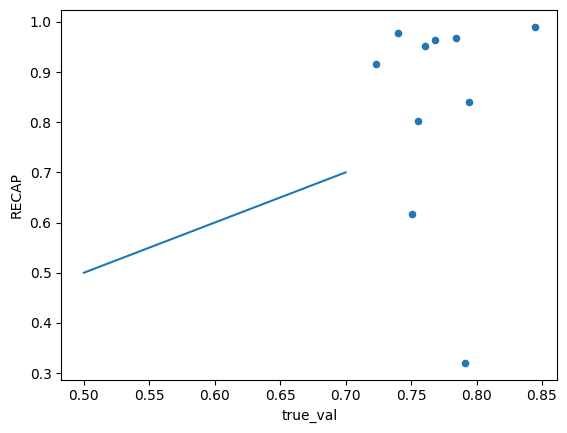

In [36]:
import matplotlib.pyplot as plt

pd.DataFrame(result).plot.scatter('true_val', 'RECAP')
plt.plot([0.5,.7], [0.5,.7])
plt.show()

In [37]:
result_df.corr()

,NM,IPS,SMIPS,BIPW,RECAP,true_val
NM,1.000000,-0.381597,0.388993,0.844391,-0.115723,-0.084953
IPS,-0.381597,1.000000,-0.063965,-0.174141,0.165558,-0.175328
SMIPS,0.388993,-0.063965,1.000000,0.210795,-0.118032,0.712042
BIPW,0.844391,-0.174141,0.210795,1.000000,-0.165092,-0.140661
RECAP,-0.115723,0.165558,-0.118032,-0.165092,1.000000,-0.026669
true_val,-0.084953,-0.175328,0.712042,-0.140661,-0.026669,1.000000


In [35]:
bandit_data["action_embed"]

NameError: name 'val_bandit_data' is not defined